In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as an
import scanpy as sc
import pandas as pd

In [2]:
#Set path
data_path = '../SourceData/Figure3/'

# Plot waveforms (Figure3c)

CM_EC channels: 31
CM channels: 30


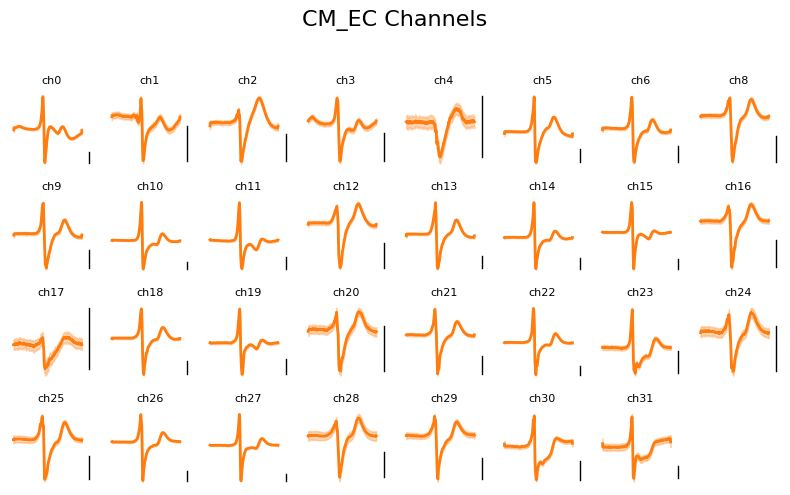

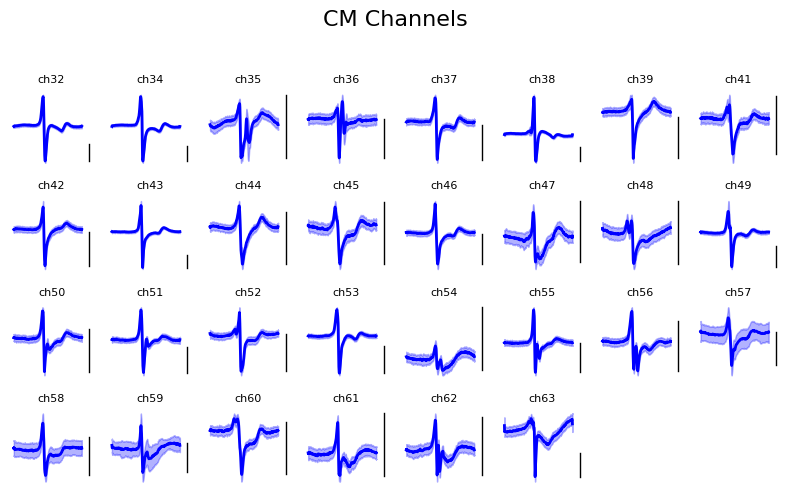

In [3]:
loaded_data = np.load(data_path + "Figure3c_waveforms.npz", allow_pickle=True)

mean_waveforms = loaded_data["mean_waveforms"].item()  
std_waveforms = loaded_data["std_waveforms"].item()   
channels = loaded_data["channels"]
regions = loaded_data["regions"]

cm_ec_channels = []
cm_channels = []

for i, (channel, region) in enumerate(regions):
    if region == "CM_EC":
        cm_ec_channels.append(channel)
    elif region == "CM":
        cm_channels.append(channel)

print(f"CM_EC channels: {len(cm_ec_channels)}")
print(f"CM channels: {len(cm_channels)}")

a = 4  # number of rows
b = 8  # number of columns

# Plot CM_EC channels
c = 1 
fig = plt.figure(figsize=(8, 5))
plt.suptitle("CM_EC Channels", fontsize=16)

for ch in cm_ec_channels:
    if c > a*b:  
        break
        
    plt.subplot(a, b, c)
    plt.title(f'{ch}', fontsize=8)
    
    plt.plot(mean_waveforms[ch], color='#ff7c0e', linewidth=2)
    plt.fill_between(np.arange(len(mean_waveforms[ch])), 
                     mean_waveforms[ch] - std_waveforms[ch], 
                     mean_waveforms[ch] + std_waveforms[ch], 
                     color='#ff7c0e', alpha=0.3)
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    
    scale_y = [np.min(mean_waveforms[ch]), np.min(mean_waveforms[ch]) + 20]
    scale_x = [10000, 10000] 
    ax.plot(scale_x, scale_y, 'k-', linewidth=1)
    
    c = c + 1

plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()

c = 1  
fig = plt.figure(figsize=(8, 5))
plt.suptitle("CM Channels", fontsize=16)

for ch in cm_channels:
    if c > a*b:  
        break
        
    plt.subplot(a, b, c)
    plt.title(f'{ch}', fontsize=8)
    
    plt.plot(mean_waveforms[ch], color='blue', linewidth=2)
    plt.fill_between(np.arange(len(mean_waveforms[ch])), 
                     mean_waveforms[ch] - std_waveforms[ch], 
                     mean_waveforms[ch] + std_waveforms[ch], 
                     color='blue', alpha=0.3)
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    
    scale_y = [np.min(mean_waveforms[ch]), np.min(mean_waveforms[ch]) + 20]
    scale_x = [10000, 10000]  
    ax.plot(scale_x, scale_y, 'k-', linewidth=1)
    
    c = c + 1

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

# Load Anndata

In [4]:
waveform_mean_denoised = sc.read_h5ad(data_path + 'Figure3_waveforms_mean_denoised.h5ad')
waveform_mean_denoised.obs_names_make_unique()

# UMAP (Figure 3d)

In [5]:
sc.tl.pca(waveform_mean_denoised, svd_solver='arpack')
sc.pp.neighbors(waveform_mean_denoised)
sc.tl.umap(waveform_mean_denoised)

waveform_mean_denoised.obsm['X_umap'].shape

(61, 2)

/opt/anaconda3/envs/graphene_electro_seq/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


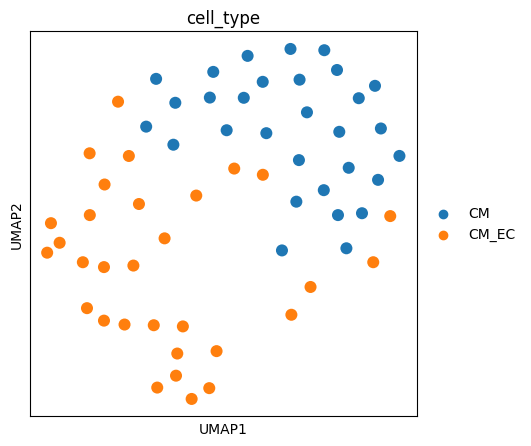

In [6]:
fig, ax = plt.subplots(figsize=(5, 5))

sc.pl.umap(waveform_mean_denoised, color=['cell_type'], size=300, ax=ax, show=False)
plt.show()


# Read Gene Dataset

In [7]:
# All transcriptomic datset
st_ad = sc.read_h5ad(data_path + 'st_ad_all.h5ad')

cell_type_dict = {
    'Unidentified': '#1f77b4',  
    'CM_s1': '#ff7f0e',         
    'CM_s2': '#2ca02c',          
    'CM_s3': '#d62728',          
    'Endothelial': '#9467bd',    
    'Fibroblast': '#8c564b'      
}

niche_type_dict = {
    'Niche_1': '#17becf',  
    'Niche_2': '#bcbd22', 
    'Niche_3': '#ff9896'   
}

# UMAPS (Figure 3 h,i)

/opt/anaconda3/envs/graphene_electro_seq/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


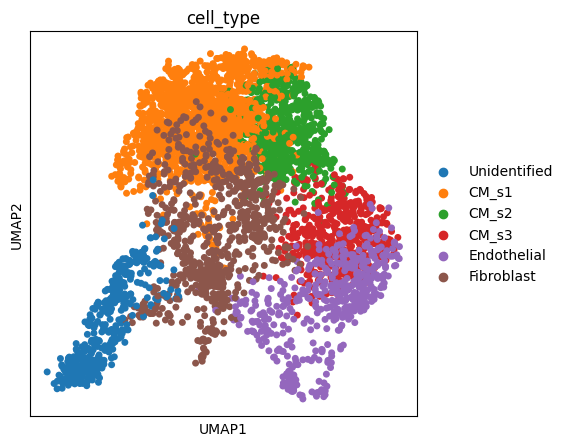

In [8]:
with plt.rc_context({"figure.figsize": (5, 5), "figure.dpi": 100}):
    ax = sc.pl.umap(st_ad, color=['cell_type'], s=100, show=False)
    plt.show()

/opt/anaconda3/envs/graphene_electro_seq/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


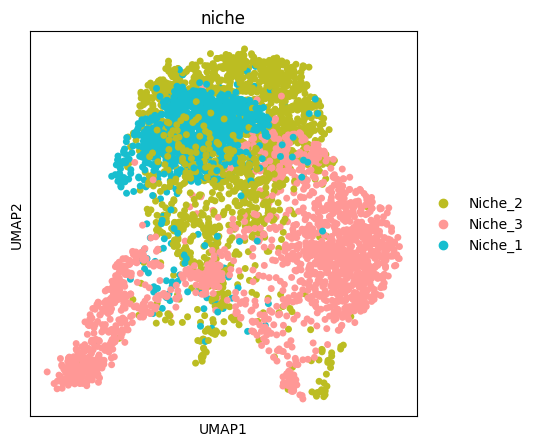

In [9]:
with plt.rc_context({"figure.figsize": (5, 5), "figure.dpi": 100}):
    ax = sc.pl.umap(st_ad, color=['niche'], s=100, palette=niche_type_dict, show=False)
    plt.show()

# Niche composition (Figure 3j)

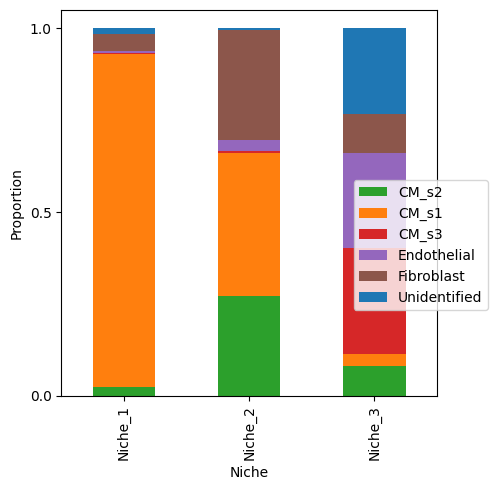

In [10]:
cell_type_niche_composition_df = pd.read_csv(data_path + 'Figure3l_cell_type_niche_composition_df.csv', index_col=0)
cell_type_niche_composition_norm_df = cell_type_niche_composition_df.div(cell_type_niche_composition_df.sum(axis=1), axis=0)

with plt.rc_context({"figure.figsize": (5, 5), "figure.dpi": 100}):
    ax = cell_type_niche_composition_norm_df.plot(kind='bar', stacked=True, color=cell_type_dict)
    ax.set_ylabel('Proportion')
    ax.set_xlabel('Niche')
    
    ax.set_yticks([0.0, 0.5, 1.0])
    
    ax.legend(bbox_to_anchor=(1, 0.5), loc="center right", bbox_transform=plt.gcf().transFigure)
    
    plt.tight_layout()

    plt.show()

# CM states vs Niche (Figure 3k)

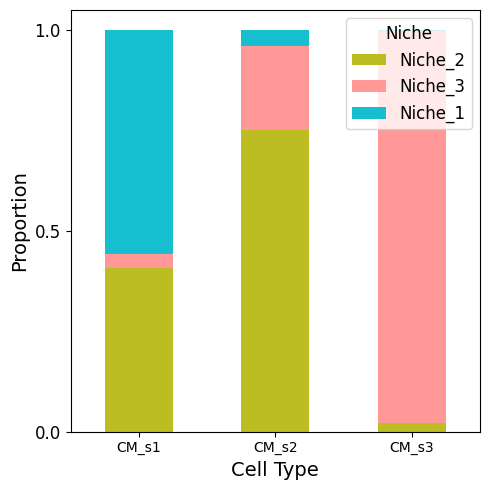

In [11]:
st_ad_electrogenic = st_ad[st_ad.obs['cell_type'].isin(['CM_s1', 'CM_s2', 'CM_s3'])]
data_i = st_ad_electrogenic

contingency_table = pd.crosstab(data_i.obs['cell_type'], data_i.obs['niche'])
proportions = contingency_table.div(contingency_table.sum(axis=1), axis=0)

with plt.rc_context({"figure.figsize": (5, 5), "figure.dpi": 100}):
    ax = proportions.plot(kind='bar', stacked=True, color=[niche_type_dict[str(i)] for i in proportions.columns])
    
    ax.set_ylabel('Proportion', fontsize=14)
    ax.set_xlabel('Cell Type', fontsize=14)
    ax.tick_params(axis='x', rotation=0)
    ax.tick_params(axis='y', labelsize=12)
    
    ax.set_yticks([0.0, 0.5, 1.0])
    
    ax.legend(title="Niche", loc="upper right", fontsize=12, title_fontsize=12, frameon=True)
    
    plt.tight_layout()
    plt.show()

# Tissue region vs CM states (Figure 3l)

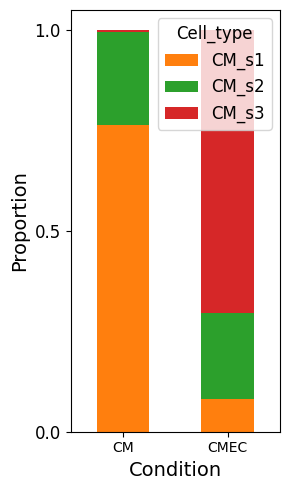

In [12]:
contingency_table = pd.crosstab(data_i.obs['condition'], data_i.obs['cell_type'])
proportions = contingency_table.div(contingency_table.sum(axis=1), axis=0)

with plt.rc_context({"figure.figsize": (3, 5), "figure.dpi": 100}):
    ax = proportions.plot(kind='bar', stacked=True, color=[cell_type_dict[str(i)] for i in proportions.columns])
    
    ax.set_ylabel('Proportion', fontsize=14)
    ax.set_xlabel('Condition', fontsize=14)
    ax.tick_params(axis='x', rotation=0)
    ax.tick_params(axis='y', labelsize=12)
    
    ax.set_yticks([0.0, 0.5, 1.0])
    
    ax.legend(title="Cell_type", loc="upper right", fontsize=12, title_fontsize=12, frameon=True)
    
    plt.tight_layout()
    plt.show()

# Pseudotime analysis

In [13]:
sc_ad_recorded = sc.read_h5ad(data_path + 'st_ad_recorded_filtered.h5ad')

# Plot

/opt/anaconda3/envs/graphene_electro_seq/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


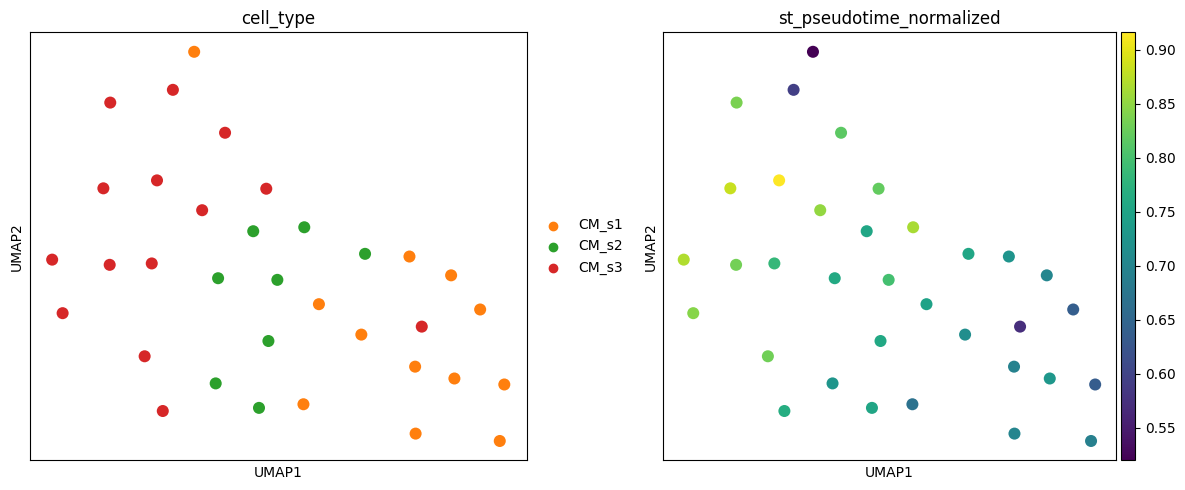

In [14]:
palette = {'CM_s1': '#ff7f0e', 'CM_s2': '#2ca02c', 'CM_s3': '#d62728'}

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))  

axs1 = sc.pl.umap(sc_ad_recorded, color=['cell_type'], size=300, palette= palette, ax=ax[0], show=False) 
axs2 = sc.pl.umap(sc_ad_recorded, color=['st_pseudotime_normalized'], size=300, ax=ax[1], show=False) 

plt.tight_layout()
plt.show()

/var/folders/qc/my6pktfj2x37y67dq8r1g28c0000gn/T/ipykernel_84019/1634695780.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


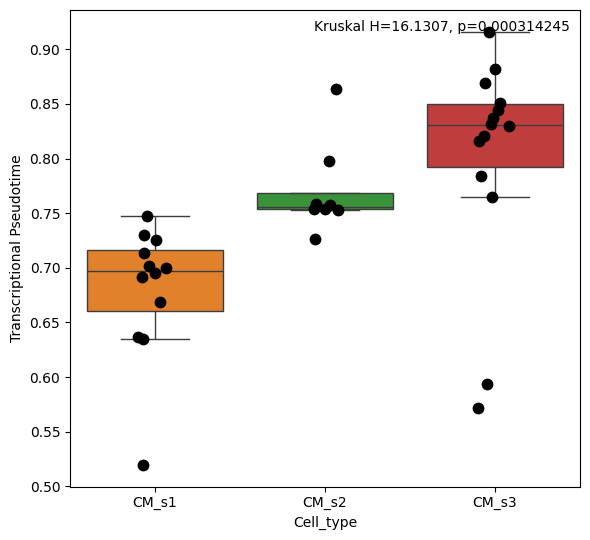

In [ ]:
from scipy.stats import kruskal

plot_data = pd.DataFrame({
    'pseudotime': sc_ad_recorded.obs['st_pseudotime_normalized'],
    'cell_type': sc_ad_recorded.obs['cell_type']
})

palette_cell_type = {
    'CM_s1': '#ff7f0e',          
    'CM_s2': '#2ca02c',         
    'CM_s3': '#d62728',          
}

order = ['CM_s1', 'CM_s2', 'CM_s3']

plt.figure(figsize=(6, 5.5))

sns.boxplot(
    data=plot_data,
    x='cell_type',
    y='pseudotime',
    palette=palette_cell_type,
    order=order,
    showfliers=False, 
)

sns.stripplot(
    data=plot_data,
    x='cell_type',
    y='pseudotime',
    order=order,
    color='black', 
    jitter=0.1,    
    size=8.5
)

plt.xlabel('Cell_type')
plt.ylabel('Transcriptional Pseudotime')

# Kruskal-Wallis across all three groups (non-parametric ANOVA)
ax = plt.gca()
vals = [
    plot_data.loc[plot_data['cell_type'] == ct, 'pseudotime'].dropna()
    for ct in order
]
if all(len(v) > 1 for v in vals):
    h_stat, h_pval = kruskal(*vals)
    ax.text(0.98, 0.98, f"Kruskal H={h_stat:.6g}, p={h_pval:.6g}", transform=ax.transAxes,
            ha='right', va='top')

plt.tight_layout()
plt.show()